<a href="https://colab.research.google.com/github/eysaritas/Diabetes-Prediction-System-/blob/main/CoinSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Importing of Relevant Libraries

In [8]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

## 2 - SIFT Algorithm Function

In [24]:
TEST_IMAGE = "ornek2.jpeg"  # Image to be tested
REF_DIR = "."         # The folder containing references

def get_sift_features(img_bgr):
    if img_bgr is None: return None, None
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

## 3 - Data Preprocessing

In [10]:
def preProcessing(img):
    # RGB to GRAY convert
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Gaussian Blur
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 3)

    # Canny Edge Detector
    imgCanny = cv2.Canny(imgBlur, 30, 150)

    # Morphological processes
    kernel = np.ones((3, 3), np.uint8)
    imgDilate = cv2.dilate(imgCanny, kernel, iterations=2)
    imgClosed = cv2.morphologyEx(imgDilate, cv2.MORPH_CLOSE, kernel)

    return imgClosed

## 4 - Determining the Value from the File Name

In [11]:
def parse_value_from_filename(filename):

    name = filename.lower()
    if "1tl" in name: return 1.00
    if "50kr" in name or "50krs" in name: return 0.50
    if "25kr" in name or "25krs" in name: return 0.25
    if "10kr" in name or "10krs" in name: return 0.10
    if "5kr" in name or "5krs" in name: return 0.05
    if "1kr" in name or "1krs" in name: return 0.01
    return 0.0

## 5 - SIFT Algorithm Extracts Features from Relevant Photos

In [21]:
def load_reference_library(ref_directory):

    print("Scanning the reference pool...")
    reference_data = []

    if not os.path.exists(ref_directory):
        print(f"ERROR: Folder not found. -> {ref_directory}")
        return []

    files = [f for f in os.listdir(ref_directory)
             if f.startswith("ref_") and (f.endswith(".jpg") or f.endswith(".png"))]

    for f in files:
        val = parse_value_from_filename(f)
        if val > 0:
            path = os.path.join(ref_directory, f)
            img = cv2.imread(path)
            kp, des = get_sift_features(img)
            if des is not None:
                reference_data.append({"name": f, "value": val, "kp": kp, "des": des})
                print(f"-> Added: {f} ({val} TL)")

    if not reference_data:
        print("WARNING: No reference files could be uploaded!")

    return reference_data

## 6 - Comparing the Given Image with Reference Data

In [18]:
def analyze_coin_image(img, reference_data):

# It returns the following:
#   - imgDisplay: Color image of the result with a box drawn on it.
#   - imgPre: Black and white pre-processing image.
#   - total_money: Calculated total amount.

    if img is None:
        print("ERROR: The image was blank (None).")
        return None, None, 0.0

    imgDisplay = img.copy()
    imgPre = preProcessing(img)

    # Finding Contours
    contours, _ = cv2.findContours(imgPre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    total_money = 0.0
    bf = cv2.BFMatcher()

    print(f"\nAnalyzing... ({len(contours)} objects found)")

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 800:
            x, y, w, h = cv2.boundingRect(cnt)
            imgCrop = img[y:y+h, x:x+w]
            kp_crop, des_crop = get_sift_features(imgCrop)

            if des_crop is None or len(kp_crop) < 5: continue

            best_match_val = 0
            max_good_matches = 0

            # Reference Matching
            for ref in reference_data:
                if ref["des"] is None: continue

                matches = bf.knnMatch(des_crop, ref["des"], k=2)
                good_matches = []
                for m, n in matches:
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)

                if len(good_matches) > max_good_matches:
                    max_good_matches = len(good_matches)
                    best_match_val = ref["value"]

            # Plot the Results (Threshold: 10 matches)
            if max_good_matches >= 10:
                total_money += best_match_val
                cv2.rectangle(imgDisplay, (x, y), (x+w, y+h), (0, 255, 0), 2)

                label = f"{int(best_match_val*100)} Kr" if best_match_val < 1 else f"{int(best_match_val)} TL"
                cv2.putText(imgDisplay, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            else:
                cv2.rectangle(imgDisplay, (x, y), (x+w, y+h), (0, 0, 255), 2)

    return imgDisplay, imgPre, total_money

## 7 - Displaying the results (Side-by-Side)

In [26]:
def display_results(imgPre, imgDisplay, total_money):

    if imgPre is None or imgDisplay is None:
        return

    # GRAY to RGB convert
    imgPre_BGR = cv2.cvtColor(imgPre, cv2.COLOR_GRAY2BGR)

    # Add Headings
    cv2.putText(imgPre_BGR, "1. Preprocessing:", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(imgDisplay, f"2. Result: {total_money:.2f} TL", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    # Combine two images side by side.
    stacked_img = np.hstack((imgPre_BGR, imgDisplay))

    print(f"\n--- TOTAL AMOUNT CALCULATED: {total_money:.2f} TL ---")
    print("Visualization: Left shows how the computer detects the boundaries, right shows the result of the identification.")

    # Display the result
    cv2_imshow(stacked_img)

## 8 - Main Function

Scanning the reference pool...
-> Added: ref_50kr_c.jpg (0.5 TL)
-> Added: ref_1tl_d.jpg (1.0 TL)
-> Added: ref_1kr_d.jpg (0.01 TL)
-> Added: ref_1kr_b.jpg (0.01 TL)
-> Added: ref_1tl_f.jpg (1.0 TL)
-> Added: ref_5kr_a.jpg (0.05 TL)
-> Added: ref_1tl_h.jpg (1.0 TL)
-> Added: ref_1kr_g.jpg (0.01 TL)
-> Added: ref_25kr_i.jpg (0.25 TL)
-> Added: ref_1tl_g.jpg (1.0 TL)
-> Added: ref_10kr_e.jpg (0.1 TL)
-> Added: ref_25kr_c.jpg (0.25 TL)
-> Added: ref_1kr_c.jpg (0.01 TL)
-> Added: ref_10kr_d.jpg (0.1 TL)
-> Added: ref_25kr_b.jpg (0.25 TL)
-> Added: ref_25kr_g.jpg (0.25 TL)
-> Added: ref_10kr_a.jpg (0.1 TL)
-> Added: ref_1kr_a.jpg (0.01 TL)
-> Added: ref_10kr_c.jpg (0.1 TL)
-> Added: ref_50kr_i.jpg (0.5 TL)
-> Added: ref_1kr_e.jpg (0.01 TL)
-> Added: ref_1tl_b.jpg (1.0 TL)
-> Added: ref_10kr_b.jpg (0.1 TL)
-> Added: ref_50kr_f.jpg (0.5 TL)
-> Added: ref_25kr_h.jpg (0.25 TL)
-> Added: ref_1tl_c.jpg (1.0 TL)
-> Added: ref_50kr_g.jpg (0.5 TL)
-> Added: ref_25kr_k.jpg (0.25 TL)
-> Added: ref_50k

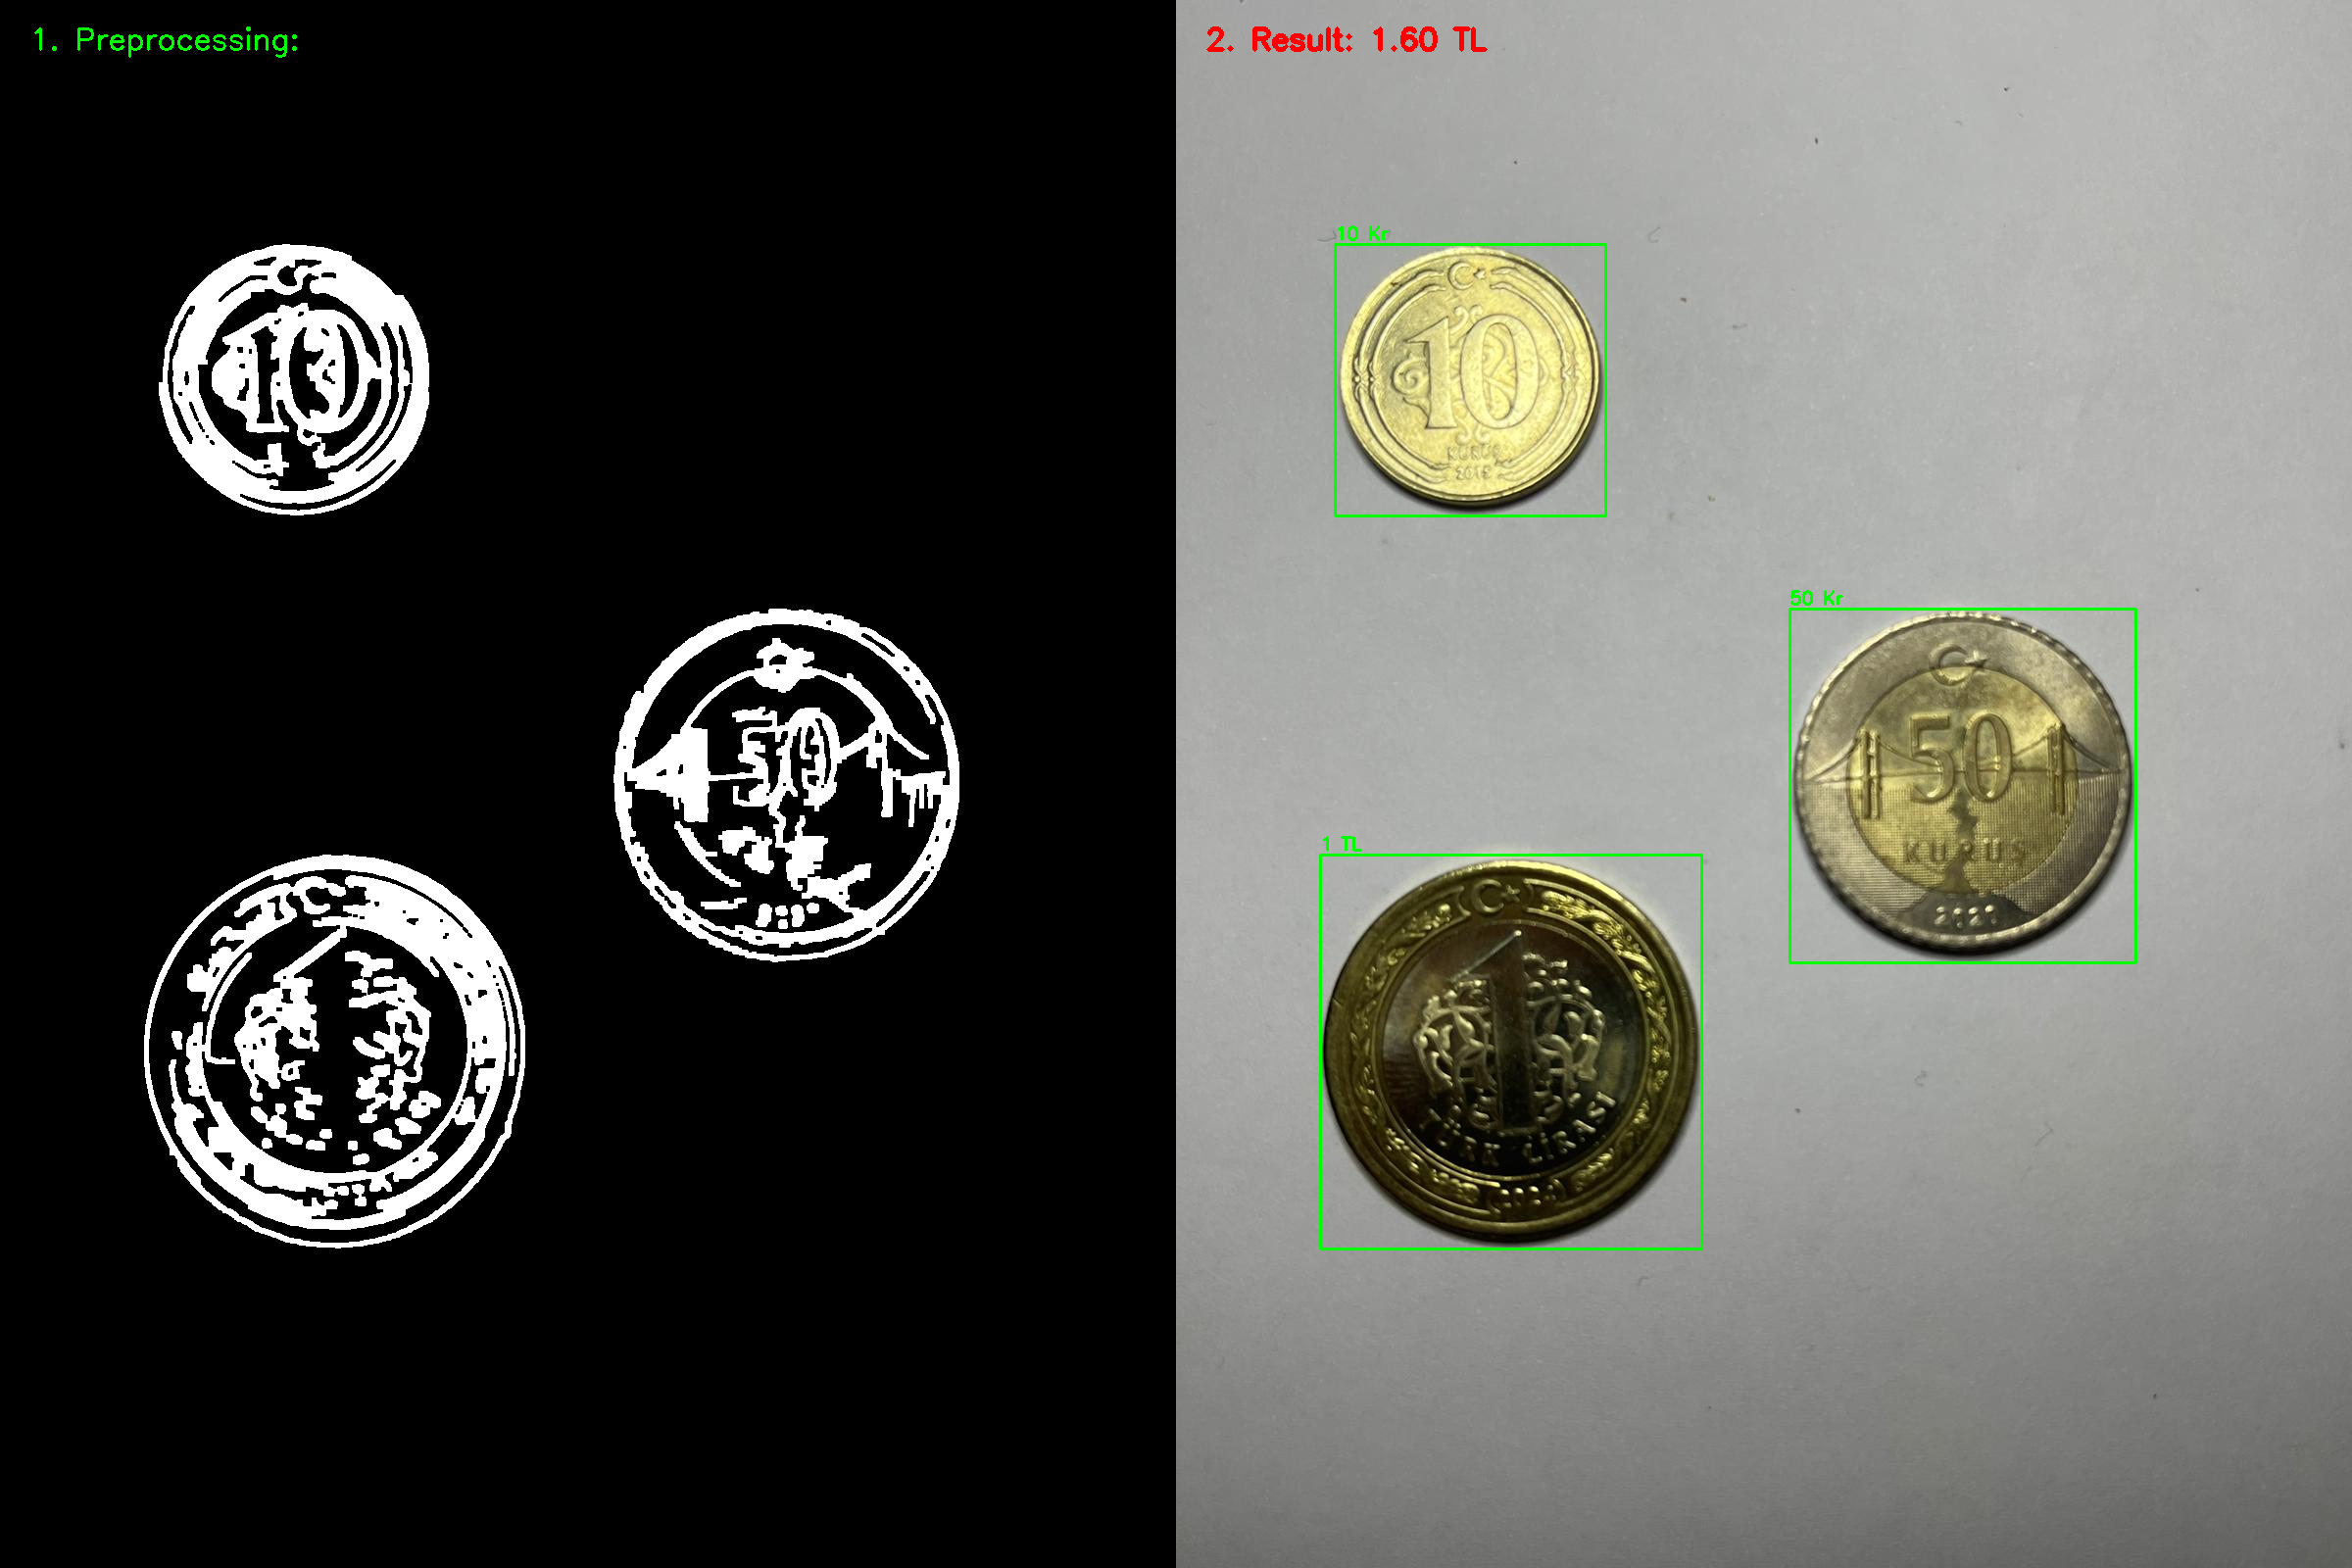

In [27]:
def main():
    # Step 1: Upload References
    refs = load_reference_library(REF_DIR)

    if not refs:
        print("ERROR: The operation was stopped because the references could not be loaded.")
        return

    # Step 2: Read the image.
    img = cv2.imread(TEST_IMAGE)
    if img is None:
        print(f"The target image ({TEST_IMAGE}) could not be found.")
        return

    # Step 3: Analyze
    result_img, pre_img, money = analyze_coin_image(img, refs)

    # Step 4: Display Results
    display_results(pre_img, result_img, money)

if __name__ == "__main__":
    main()